 - hash name
 - get python types from function type
 - add a compile function that takes (name, input types, output types) and returns a callable

In [17]:
from pathlib import Path

from xdsl.builder import ImplicitBuilder
from xdsl.dialects import arith, func, memref, scf
from xdsl.dialects.builtin import (
    ArrayAttr,
    DictionaryAttr,
    FloatAttr,
    IndexType,
    IntegerAttr,
    ModuleOp,
    UnitAttr,
    f64,
    i64,
)
from xdsl.ir import Block, Region

index = IndexType()


def get_module(n: int) -> ModuleOp:
    memref_t = memref.MemRefType(f64, [n])
    module = ModuleOp([])
    with ImplicitBuilder(module.body):
        f = func.FuncOp("hello", ((i64, i64), (i64,)))
        with ImplicitBuilder(f.body) as (lhs, rhs):
            res = arith.AddiOp(lhs, rhs).result
            func.ReturnOp(res)

        g = func.FuncOp(
            "dist",
            ((memref_t, memref_t), (f64,)),
            arg_attrs=ArrayAttr((DictionaryAttr({"llvm.noalias": UnitAttr()}),) * 2),
        )
        with ImplicitBuilder(g.body) as (lhs, rhs):
            zero = arith.ConstantOp(IntegerAttr(0, index)).result
            one = arith.ConstantOp(IntegerAttr(1, index)).result
            hundo = arith.ConstantOp(IntegerAttr(n, index)).result

            initial = arith.ConstantOp(FloatAttr(0.0, f64)).result

            body = Region(Block(arg_types=(index, f64)))
            norm_squared = scf.ForOp(zero, hundo, one, (initial,), body)
            with ImplicitBuilder(norm_squared.body) as (i, acc):
                lhs_el = memref.LoadOp.get(lhs, (i,)).res
                rhs_el = memref.LoadOp.get(rhs, (i,)).res
                sq = arith.MulfOp(lhs_el, rhs_el).result
                new_acc = arith.AddfOp(acc, sq)
                scf.YieldOp(new_acc)

            func.ReturnOp(norm_squared)

    return module


m = get_module(100)
m_str = str(m)

with open(Path() / "input.mlir", "w") as f:
    f.write(m_str)

In [18]:
import ctypes

from xdsl.jit import jit_module

dbl_ptr_type = ctypes.POINTER(ctypes.c_double)

hey = jit_module(m, "hello", types=((int, int), int))
dist_mlir = jit_module(m, "dist", types=((dbl_ptr_type, dbl_ptr_type), float))
hey(5, 6)

11

In [19]:
import numpy as np

In [20]:
n = 10000
a = np.random.random(n)
b = np.random.random(n)

In [21]:
a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
%time dist_mlir(a_data_ptr, b_data_ptr)

CPU times: user 4 μs, sys: 2 μs, total: 6 μs
Wall time: 7.87 μs


23.715386211576924

In [22]:
%time hey(5, 6)

CPU times: user 5 μs, sys: 3 μs, total: 8 μs
Wall time: 10 μs


11

In [23]:
%time 1 + 2

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 954 ns


3

In [24]:
from typing import Any


def dist_np(
    lhs: np.ndarray[Any, np.dtype[np.float64]],
    rhs: np.ndarray[Any, np.dtype[np.float64]],
) -> np.float64:
    return lhs.dot(rhs)


%time dist_np(a, b)

CPU times: user 137 μs, sys: 97 μs, total: 234 μs
Wall time: 185 μs


np.float64(2516.1218976375912)

In [25]:
def dist_python(
    lhs: np.ndarray[Any, np.dtype[np.float64]],
    rhs: np.ndarray[Any, np.dtype[np.float64]],
) -> np.float64:
    res = np.float64(0.0)
    for l, r in zip(lhs, rhs):
        res += l * r
    return res


%time dist_python(a, b)

CPU times: user 942 μs, sys: 0 ns, total: 942 μs
Wall time: 943 μs


np.float64(2516.1218976375853)

In [26]:
import timeit

timeit.timeit(lambda: dist_python(a, b), number=100)

0.10326058400096372

In [27]:
import pandas as pd

In [28]:
from collections import defaultdict

In [13]:
res = defaultdict[str, list[float]](list)

powers = [int(10**i) for i in range(1, 6)]

for n in powers:
    a = np.random.random(n)
    b = np.random.random(n)
    dist_mlir_i = jit_module(
        get_module(n), "dist", types=((dbl_ptr_type, dbl_ptr_type), float)
    )
    a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
    b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
    res["mlir"].append(
        timeit.timeit(lambda: dist_mlir_i(a_data_ptr, b_data_ptr), number=100)
    )
    res["numpy"].append(timeit.timeit(lambda: dist_np(a, b), number=100))
    res["python"].append(timeit.timeit(lambda: dist_python(a, b), number=100))

res

defaultdict(list,
            {'mlir': [0.0003861250006593764,
              6.399999256245792e-05,
              0.00012804199650418013,
              0.0009725000127218664,
              0.009101916992221959],
             'numpy': [0.0002498749963706359,
              3.354200453031808e-05,
              6.64590043015778e-05,
              9.741599205881357e-05,
              0.0003528749948600307],
             'python': [0.0001470829884056002,
              0.0009424160089110956,
              0.008582000009482726,
              0.13935066599515267,
              0.8966409170097904]})

In [14]:
df = pd.DataFrame(res, index=powers)
df

,mlir,numpy,python
10,0.000386,0.000250,0.000147
100,0.000064,0.000034,0.000942
1000,0.000128,0.000066,0.008582
10000,0.000973,0.000097,0.139351
100000,0.009102,0.000353,0.896641


In [15]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


<Axes: ylabel='seconds'>

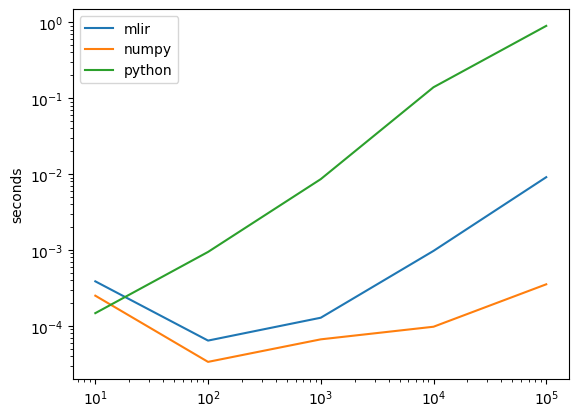

In [16]:
df.plot(logy=True, logx=True, ylabel="seconds")